In [1]:
from __future__ import print_function, division

import pickle


import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.options.display.max_columns = 40

## Goals of this notebook:

- Data Exploration
    - Outlier Detection
    - Plotting Distributions
- Feature Engineering
    - Interactions Between Features
    - Dimensionality Reduction using PCA
- Feature Selection and Model Building

## Load Data

In [3]:
import pickle
with open('Pre_Processed_IMDB_Data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)
df.head()

,tconst,primaryProfession,mpaa_rating,metacritic_score,averageRating,release,genres,Num_Theaters,Price,runtimeMinutes,release_year,release_season,weighted_score,opening_per_theater,release_1_month_prev,release_6_month_prev,release_12_month_prev,average_star_rank_12_month_1,average_star_rank_12_month_2,average_star_rank_12_month_3,average_star_rank_12_month_4,average_star_rank_12_month_5,average_star_rank_6_month_1,average_star_rank_6_month_2,average_star_rank_6_month_3,average_star_rank_6_month_4,average_star_rank_6_month_5,average_star_rank_1_month_1,average_star_rank_1_month_2,average_star_rank_1_month_3,average_star_rank_1_month_4,average_star_rank_1_month_5,average_star_rank_0_month_1,average_star_rank_0_month_2,average_star_rank_0_month_3,average_star_rank_0_month_4,average_star_rank_0_month_5,release_type
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A Walk Among the Tombstones,tt0365907,producer,R,57,6.5,2014-09-19,Crime,2712,12758780,114.0,2014,summer,6.10,4704.564897,2014-08-20,2014-03-23,2013-09-24,46.0,56.0,171.000000,313.00,1124.8,45.0,55.5,170.666667,312.75,1124.6,45.0,55.5,170.666667,300.75,644.0,34.0,50.0,167.0,260.00,513.4,wide
Pride and Prejudice and Zombies,tt1374989,producer,PG-13,45,5.8,2016-02-05,Action,2931,5324240,108.0,2016,winter,5.15,1816.526783,2016-01-06,2015-08-09,2015-02-10,3.0,34.5,50.666667,68.00,1050.0,1.0,33.5,50.000000,67.50,1049.6,1.0,33.5,50.000000,67.50,379.6,1.0,33.5,50.0,67.50,379.6,wide
Clown,tt1780798,producer,R,42,5.7,2016-06-17,Horror,100,26920,100.0,2016,spring,4.95,269.200000,2016-05-18,2015-12-20,2015-06-23,196.0,208.0,234.333333,366.75,2369.4,76.0,80.5,127.000000,286.25,2305.0,76.0,80.5,127.000000,286.25,2305.0,76.0,80.5,127.0,286.25,1919.6,limited
American Made,tt3532216,producer,R,65,7.2,2017-09-29,Action,3024,16776390,115.0,2017,autumn,6.85,5547.748016,2017-08-30,2017-04-02,2016-10-04,3.0,6.0,22.000000,39.75,154.4,3.0,6.0,22.000000,39.75,154.4,3.0,6.0,10.000000,21.00,112.8,3.0,4.5,6.0,18.00,110.4,wide
The Quiet Ones,tt2235779,producer,PG-13,41,5.1,2014-04-25,Horror,2027,3880053,98.0,2014,spring,4.60,1914.185002,2014-03-26,2013-10-27,2013-04-30,98.0,384.5,507.000000,3300.75,6330.2,69.0,236.0,408.000000,1785.75,4426.8,2.0,83.0,306.000000,520.00,1873.6,2.0,83.0,306.0,496.25,1734.0,wide


## Data Exploration

In [4]:
## Plot distributions of each non-dummy variable
var_list = ['metacritic_score', 'averageRating', 'Num_Theaters', 'Price', 'runtimeMinutes', 'release_year', 'weighted_score',
           'average_star_rank_12_month_5', 'average_star_rank_12_month_2', 'average_star_rank_12_month_3', 'average_star_rank_12_month_4', 'average_star_rank_12_month_1']
# var_list = ['Num_Theaters', 'Price', 'runtimeMinutes', 'release_year',
#            'average_star_rank_12_month_1', 'average_star_rank_12_month_2', 'average_star_rank_12_month_3', 'average_star_rank_12_month_4', 'average_star_rank_12_month_5']

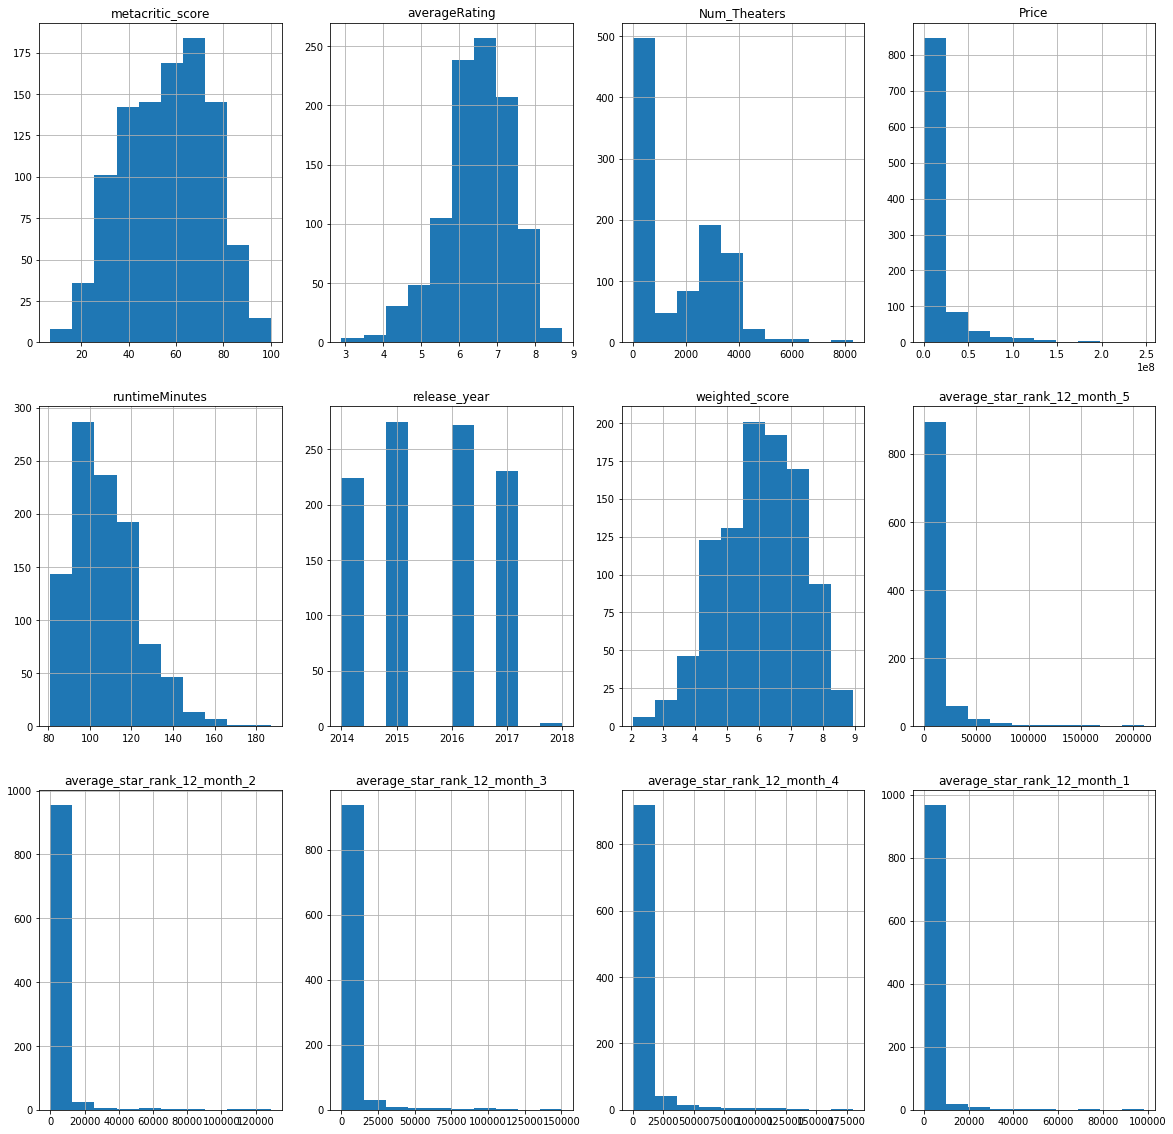

In [5]:
fig, ax = plt.subplots(3,4, figsize=(20,20))
ax = ax.reshape(len(var_list), 1)
for i in range(len(var_list)):
    df[var_list[i]].hist(ax=ax[i][0])
    ax[i][0].set_title(var_list[i])

- **metacritic\_score, averageRating, runtimeMinutes, release\_year, **and** weighted\_score** are all approximately normal distributions
- **average\_star\_rank\_12\_month\_[0-5] **and** Price** are both skewed, but this issue is solved by performing a log transform on the data

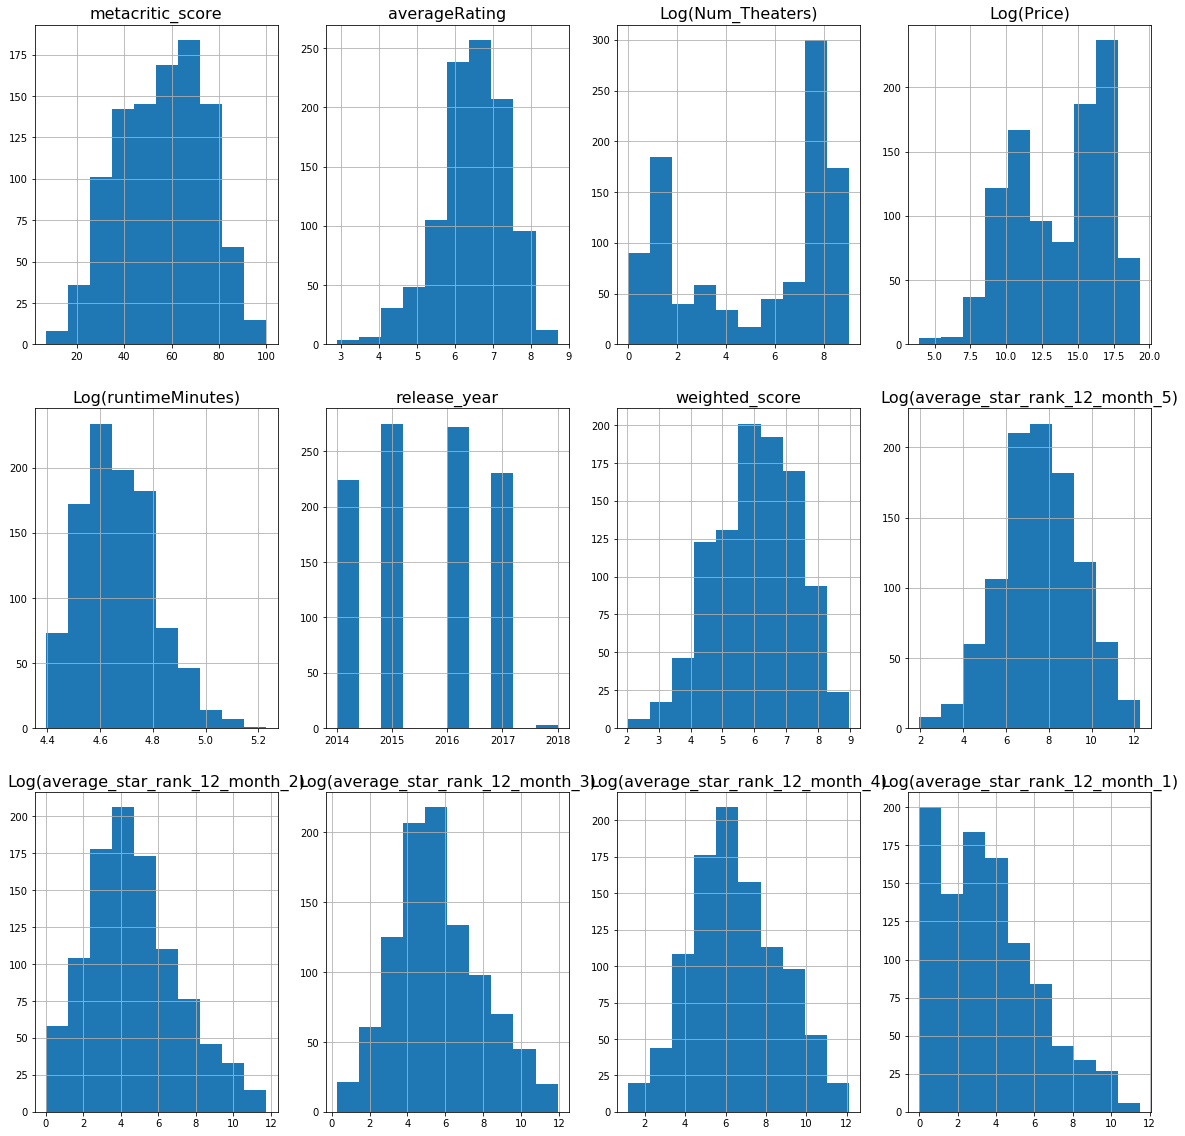

In [6]:
fig, ax = plt.subplots(3,4, figsize=(20,20))
ax = ax.reshape(len(var_list), 1)
for i in range(len(var_list)):
    if ('average_star_rank' in var_list[i]) or (var_list[i] in ['Price', 'Num_Theaters', 'runtimeMinutes']):
        df[var_list[i]].apply(np.log).hist(ax=ax[i][0])
        ax[i][0].set_title('Log('+var_list[i]+')', fontsize=16)
    else:
        df[var_list[i]].hist(ax=ax[i][0])
        ax[i][0].set_title(var_list[i], fontsize=16)

We can drop **average_star_rank_12_month_1** because it does not follow a normal distribution. **average_star_rank_12_month_5** has the most normal distribution, so we will select this initially as our feature. 

Also, **Log(Price)** appears to have a bimodal distribution, so we should treat each mode separately. We can view the split by comparing limited releases to box office releases:

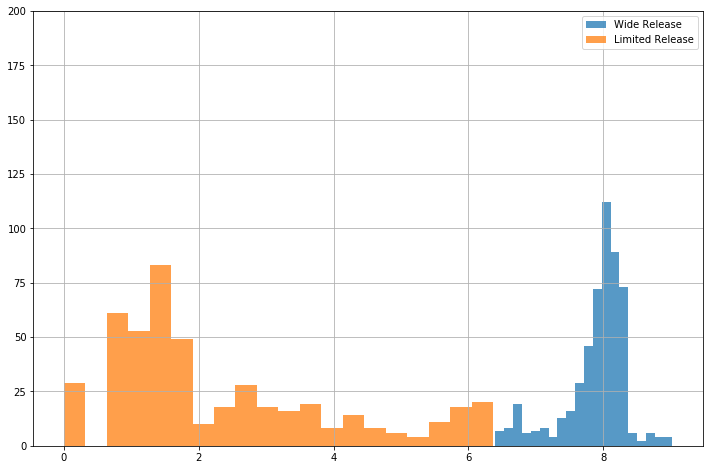

In [7]:
plt.figure(figsize=(12,8))
mask = (df['release_type'] == 'wide')
df[mask]['Num_Theaters'].apply(np.log).hist(bins=20, label='Wide Release', alpha=0.75)

mask = (df['release_type'] == 'limited')
df[mask]['Num_Theaters'].apply(np.log).hist(bins=20, label='Limited Release', alpha=0.75)

# df['Num_Theaters'].apply(np.log).hist(bins=35, label='All Data')

plt.ylim(0,200)

plt.legend();

Splitting into these two sections would yield the following distributions:

LIMITED RELEASE


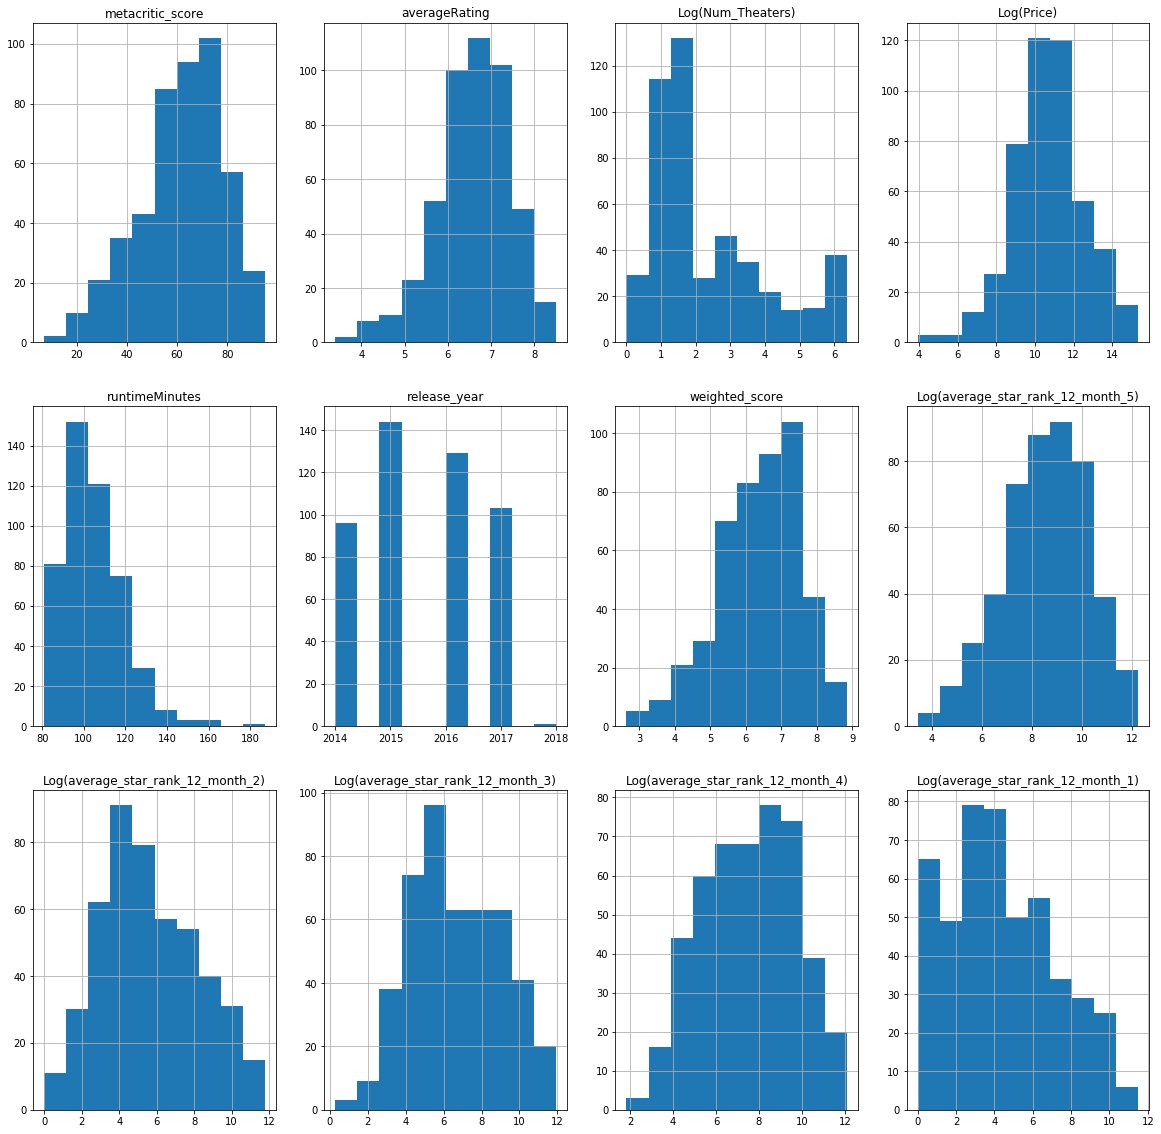

WIDE RELEASE


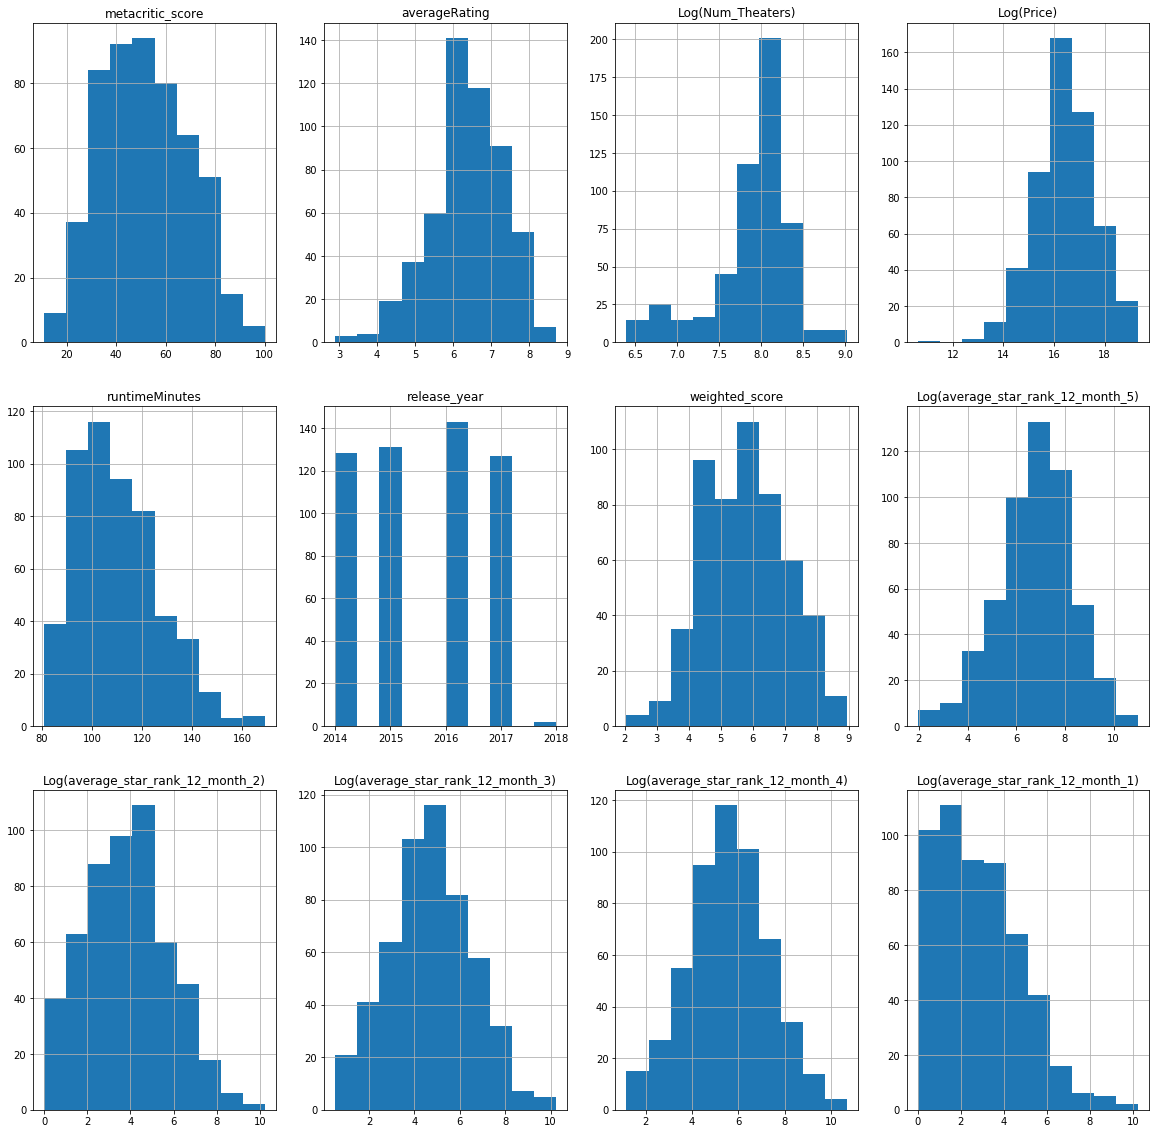

In [8]:
mask = {}
mask['limited'] = (df['release_type'] == 'limited')
mask['wide'] = (df['release_type'] == 'wide')

for m in mask:
    print (('%s release' % m).upper())
    fig, ax = plt.subplots(3,4, figsize=(20,20))
    ax = ax.reshape(len(var_list), 1)
    for i in range(len(var_list)):
        if ('average_star_rank' in var_list[i]) or (var_list[i] == 'Price') or (var_list[i] == 'Num_Theaters'):
            df[mask[m]][var_list[i]].apply(np.log).hist(ax=ax[i][0])
            ax[i][0].set_title('Log('+var_list[i]+')')
        else:
            df[mask[m]][var_list[i]].hist(ax=ax[i][0])
            ax[i][0].set_title(var_list[i])
    plt.show()
        

In [9]:
for movie in df[((df['Price'].apply(np.log) < 12) & (df['release_type'] == 'wide'))].index:
    df.drop(movie, inplace=True)

If we would like to look at all data at once, a better metric would be looking at **opening_per_theater**, which is defined as the total opening weekend box office gross divided by the number of theaters showing the film during opening weekend.

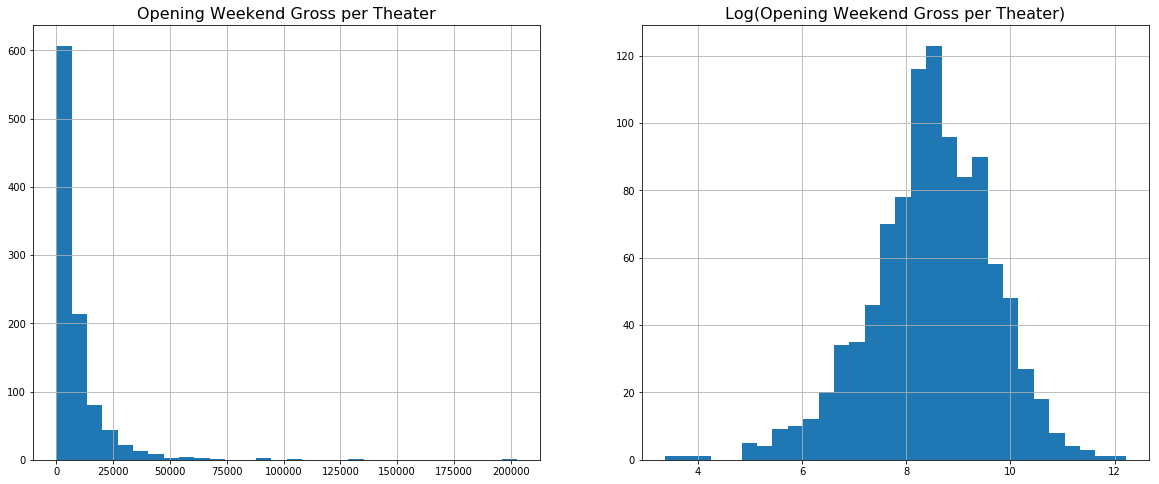

In [10]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
df['opening_per_theater'].hist(bins=30)
plt.title('Opening Weekend Gross per Theater', fontsize=16)

plt.subplot(1,2,2)
df['opening_per_theater'].apply(np.log).hist(bins=30)
plt.title('Log(Opening Weekend Gross per Theater)', fontsize=16)

In [11]:
for movie in df[df['opening_per_theater'].apply(np.log) < 4.2].index:
    df.drop(movie, inplace=True)

#### Exploring Categoricals
- Genre
- Release Season
- MPAA Rating
- Release Type

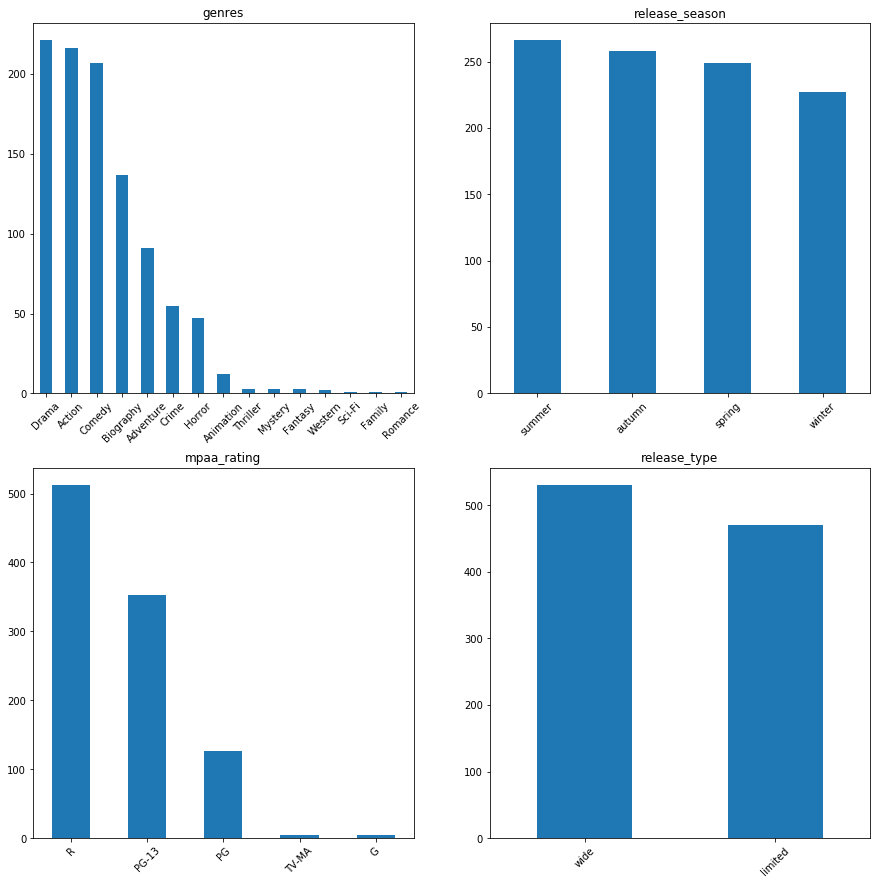

In [12]:
categoricals = ['genres', 'release_season', 'mpaa_rating', 'release_type']
plt.figure(figsize=(15,15))
for i in range(len(categoricals)):
    plt.subplot(2,2,i+1)
    df[categoricals[i]].value_counts().plot(kind='bar')
    plt.xticks(rotation=45)
    plt.title(categoricals[i])

We see a roughly even distribution of data among release seasons and release types (wide vs. limited). However, there's a clear difference in the counts of genres and mpaa_ratings. To account for these, we will do the following:

- Genres will be converted to dummy variables:
    - Drama
    - Action
    - Comedy
    - Biography
    - Adventure
    - Crime
    - Horror
    - Animation
    - Other (incl. Thriller, Mystery, Fantasy, Western, Romance, Sci-Fi, and Family)
- MPAA Ratings will also be converted to dummy variables:
    - R
    - PG-13
    - PG (incl. G)
    - (TV-MA film(s) will be removed, as this is not a typical box-office movie rating)

In [13]:
df['genres_adj'] = [x if x not in ['Thriller', 'Mystery', 'Fantasy', 'Western', 'Romance', 'Sci-Fi', 'Family', 'Animation'] else 'Other' for x in df['genres']]
df[['genres', 'genres_adj']].sample(10, random_state=42)

,genres,genres_adj
title,,
Spider-Man: Homecoming,Action,Action
The SpongeBob Movie: Sponge Out of Water,Adventure,Adventure
Vampire Academy,Action,Action
The Mountain Between Us,Action,Action
Maudie,Biography,Biography
Dumb and Dumber To,Adventure,Adventure
Mike and Dave Need Wedding Dates,Adventure,Adventure
Hidden Figures,Biography,Biography
A Quiet Passion,Biography,Biography


In [14]:
# Convert 'G' to 'PG'
df['mpaa_rating_adj'] = [x if x != 'G' else 'PG' for x in df['mpaa_rating']]

# Remove 'TV-MA' Films
df.drop(list(df[df['mpaa_rating'] == 'TV-MA'].index), inplace=True)

# Print Results
df[['mpaa_rating', 'mpaa_rating_adj']].sort_values('mpaa_rating').head(10)

,mpaa_rating,mpaa_rating_adj
title,,
The Peanuts Movie,G,PG
Rio 2,G,PG
The Eagle Huntress,G,PG
Cars 3,G,PG
The Wedding Plan,PG,PG
Penguins of Madagascar,PG,PG
Kubo and the Two Strings,PG,PG
Paddington 2,PG,PG
The SpongeBob Movie: Sponge Out of Water,PG,PG


Now if we re-plot the data:

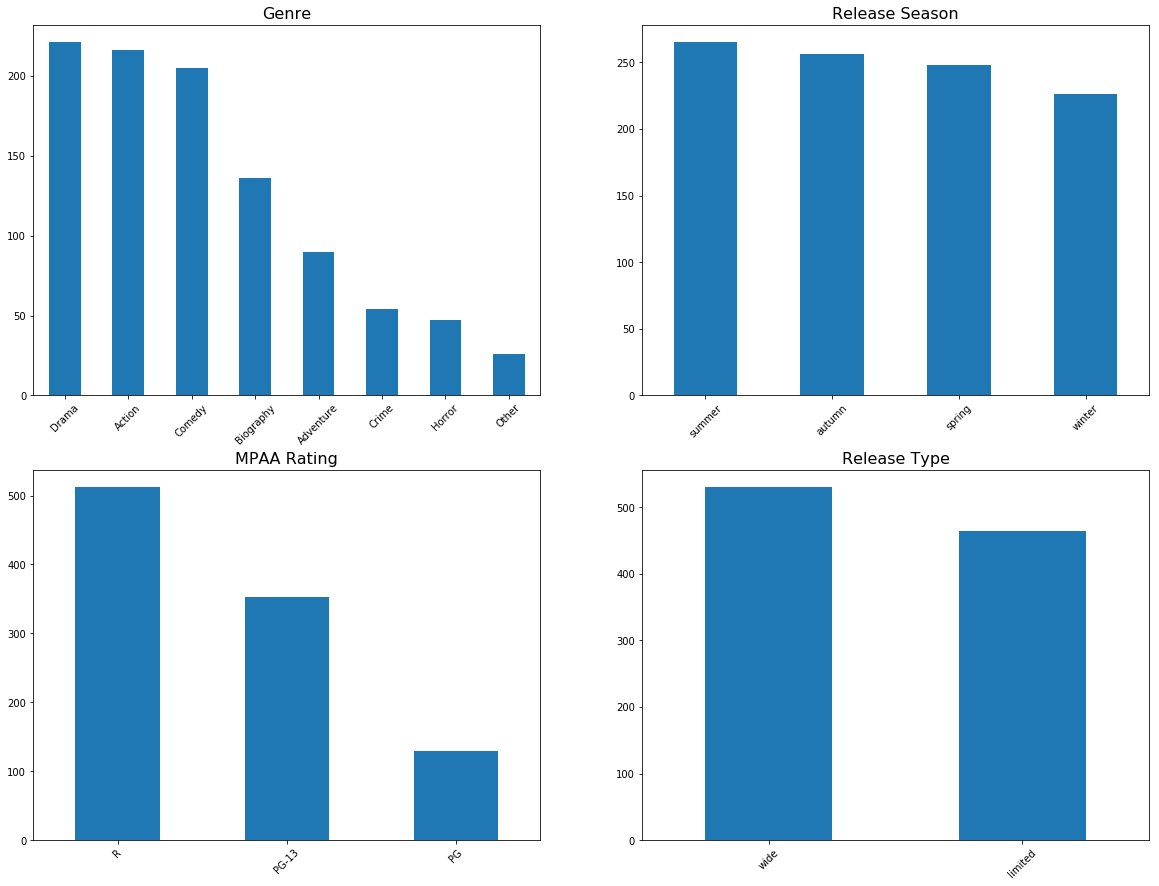

In [15]:
categoricals = ['genres_adj', 'release_season', 'mpaa_rating_adj', 'release_type']
titles = ['Genre', 'Release Season', 'MPAA Rating', 'Release Type']
plt.figure(figsize=(20,15))
for i, title in zip(range(len(categoricals)), titles):
    plt.subplot(2,2,i+1)
    df[categoricals[i]].value_counts().plot(kind='bar')
    plt.xticks(rotation=45)
    plt.title(title, fontsize=16)

That's better. Let's make some dummy variables!

In [16]:
df_with_dummies = df.join(pd.get_dummies(df['genres_adj'], prefix='dum_is', drop_first=False).iloc[:,:-1])
df_with_dummies = df_with_dummies.join(pd.get_dummies(df['mpaa_rating_adj'], prefix='dum_rated', drop_first=True))
df_with_dummies = df_with_dummies.join(pd.get_dummies(df['release_season'], prefix='dum_release_in', drop_first=True))
df_with_dummies = df_with_dummies.join(pd.get_dummies(df['release_type'], prefix='dum_release', drop_first=False).iloc[:,:-1])
df_with_dummies.drop(['tconst', 'primaryProfession', 'mpaa_rating', 'mpaa_rating_adj', 'metacritic_score', 
                      'averageRating', 'release', 'genres', 'genres_adj', 'release_season', 'release_type', 'weighted_score'],
                     axis=1, inplace=True)
drop_names = []
for name in df_with_dummies.columns:
    if any(name.endswith(x) for x in ['_1', '_2', '_3', '_4', '_prev']):
        drop_names.append(name)
df_with_dummies.drop(drop_names, axis=1, inplace=True)
df_with_dummies.head()

,Num_Theaters,Price,runtimeMinutes,release_year,opening_per_theater,average_star_rank_12_month_5,average_star_rank_6_month_5,average_star_rank_1_month_5,average_star_rank_0_month_5,dum_is_Action,dum_is_Adventure,dum_is_Biography,dum_is_Comedy,dum_is_Crime,dum_is_Drama,dum_is_Horror,dum_rated_PG-13,dum_rated_R,dum_release_in_spring,dum_release_in_summer,dum_release_in_winter,dum_release_limited
title,,,,,,,,,,,,,,,,,,,,,,
A Walk Among the Tombstones,2712,12758780,114.0,2014,4704.564897,1124.8,1124.6,644.0,513.4,0,0,0,0,1,0,0,0,1,0,1,0,0
Pride and Prejudice and Zombies,2931,5324240,108.0,2016,1816.526783,1050.0,1049.6,379.6,379.6,1,0,0,0,0,0,0,1,0,0,0,1,0
Clown,100,26920,100.0,2016,269.200000,2369.4,2305.0,2305.0,1919.6,0,0,0,0,0,0,1,0,1,1,0,0,1
American Made,3024,16776390,115.0,2017,5547.748016,154.4,154.4,112.8,110.4,1,0,0,0,0,0,0,0,1,0,0,0,0
The Quiet Ones,2027,3880053,98.0,2014,1914.185002,6330.2,4426.8,1873.6,1734.0,0,0,0,0,0,0,1,1,0,1,0,0,0


In [17]:
label = ['opening_per_theater', 'Price']
key_feature = ['average_star_rank_12_month_5',
               'average_star_rank_6_month_5',
               'average_star_rank_1_month_5',
               'average_star_rank_0_month_5']
other_features = []
for col in df_with_dummies.columns:
    if col not in label and col not in key_feature:
        other_features.append(col)
        
df_with_dummies.dropna(inplace=True)
df_with_dummies.drop_duplicates(inplace=True)

print("Number of Data Points (m): %d" % len(df_with_dummies))
print("Number of Features    (n): %d" % (len(other_features)+1))

Number of Data Points (m): 990
Number of Features    (n): 17


## Interactions Between Features

First, looking at just the key features (average star rank)

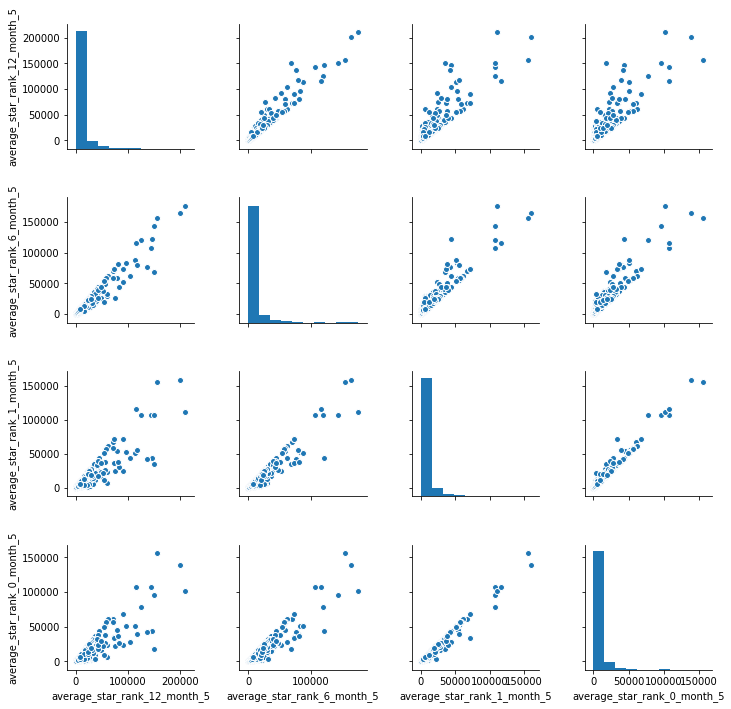

In [18]:
sns.pairplot(df_with_dummies[key_feature])

In [19]:
df_with_dummies[key_feature].corr()

,average_star_rank_12_month_5,average_star_rank_6_month_5,average_star_rank_1_month_5,average_star_rank_0_month_5
average_star_rank_12_month_5,1.000000,0.972517,0.913304,0.896833
average_star_rank_6_month_5,0.972517,1.000000,0.959879,0.946996
average_star_rank_1_month_5,0.913304,0.959879,1.000000,0.987959
average_star_rank_0_month_5,0.896833,0.946996,0.987959,1.000000


Very highly correlated, so we will select only one (**average_star_rank_12_month_5**)

Looking at the other features with this one added in, as well as the first label (**opening_per_theater**):

In [20]:
def log_update_features(df):
    for col_name in df.columns:
        if col_name.startswith('average_star_rank') or (col_name in ['Price', 'opening_per_theater', 'Num_Theaters', 'runtimeMinutes']):
            df[col_name] = df[col_name].apply(np.log)
    return df

In [21]:
features = other_features + [key_feature[0]] + [label[1]]
non_dummy_features = [f for f in features if f[:3] != 'dum']
# grid = sns.pairplot(log_update_features(df_with_dummies[non_dummy_features + ['dum_release_limited']]), hue='dum_release_limited')


In [22]:
log_update_features(df_with_dummies[features]).corr().abs().unstack().sort_values(ascending=False)[:50]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Price                         Price                           1.000000
dum_is_Drama                  dum_is_Drama                    1.000000
dum_release_in_winter         dum_release_in_winter           1.000000
dum_release_in_summer         dum_release_in_summer           1.000000
dum_release_in_spring         dum_release_in_spring           1.000000
dum_rated_R                   dum_rated_R                     1.000000
dum_rated_PG-13               dum_rated_PG-13                 1.000000
dum_is_Horror                 dum_is_Horror                   1.000000
dum_is_Crime                  dum_is_Crime                    1.000000
average_star_rank_12_month_5  average_star_rank_12_month_5    1.000000
dum_is_Comedy                 dum_is_Comedy                   1.000000
dum_is_Biography              dum_is_Biography                1.000000
dum_is_Adventure              dum_is_Adventure                1.000000
dum_is_Action                 dum_is_Action                   1.000000
releas

In [23]:
X = log_update_features(df_with_dummies[other_features + [key_feature[0]]])
y = log_update_features(pd.DataFrame(df_with_dummies[label[0]]))

X_limited = log_update_features(df_with_dummies[df_with_dummies['dum_release_limited'] == 1][other_features + [key_feature[0]]]).drop('dum_release_limited', axis=1)
y_limited = log_update_features(pd.DataFrame(df_with_dummies[df_with_dummies['dum_release_limited'] == 1][label[1]]))

X_wide = log_update_features(df_with_dummies[df_with_dummies['dum_release_limited'] == 0][other_features + [key_feature[0]]]).drop('dum_release_limited', axis=1)
y_wide = log_update_features(pd.DataFrame(df_with_dummies[df_with_dummies['dum_release_limited'] == 0][label[1]]))


split_features = [f for f in [other_features + [key_feature[0]]] if f != 'dum_release_limited']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
# Summary for all features
from sklearn.preprocessing import PolynomialFeatures
def get_ols_fit(X, y):
    all_features = y.columns[0] + " ~ " + " + ".join(["Q('"+x+"')" for x in X.columns])
    all_features
    y_ols, X_ols = patsy.dmatrices(all_features, data=X.join(y), return_type='dataframe')
    model = sm.OLS(y_ols, X_ols)
    fit = model.fit()
    return fit

In [25]:
fit = get_ols_fit(X, y)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     opening_per_theater   R-squared:                       0.214
Model:                             OLS   Adj. R-squared:                  0.200
Method:                  Least Squares   F-statistic:                     15.56
Date:                 Mon, 29 Jan 2018   Prob (F-statistic):           1.65e-40
Time:                         11:32:57   Log-Likelihood:                -1424.9
No. Observations:                  990   AIC:                             2886.
Df Residuals:                      972   BIC:                             2974.
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            18.0114     63.439      0.284      0.777    -106.482     142.504
Q('Num_Theaters')                    -0.2987      0.028    -10.613      0.000      -0.354      -0.243
Q('runtimeMinutes')                   2.0799      0.268      7.751      0.000       1.553       2.607
Q('release_year')                    -0.0079      0.031     -0.250      0.802      -0.070       0.054
Q('dum_is_Action')                    0.1864      0.222      0.838      0.402      -0.250       0.623
Q('dum_is_Adventure')                 0.3005      0.235      1.280      0.201      -0.160       0.761
Q('dum_is_Biography')                 0.0634      0.225      0.281      0.778      -0.379       0.506
Q('dum_is_Comedy')                    0.1231      0.218      0.564      0.573      -0.305       0.551
Q('dum_is_Crime')                    -0.0511      0.254     -0.202      0.840      -0.549       0.447
Q('dum_is_Drama')                    -0.1605      0.217     -0.739      0.460      -0.587       0.266
Q('dum_is_Horror')                    0.0166      0.260      0.064      0.949      -0.493       0.527
Q('dum_rated_PG-13')                 -0.2297      0.122     -1.879      0.061      -0.470       0.010
Q('dum_rated_R')                     -0.5153      0.122     -4.206      0.000      -0.756      -0.275
Q('dum_release_in_spring')            0.3025      0.093      3.250      0.001       0.120       0.485
Q('dum_release_in_summer')            0.2754      0.092      3.000      0.003       0.095       0.456
Q('dum_release_in_winter')            0.1084      0.096      1.123      0.262      -0.081       0.298
Q('dum_release_limited')             -1.2143      0.167     -7.289      0.000      -1.541      -0.887
Q('average_star_rank_12_month_5')    -0.1476      0.023     -6.429      0.000      -0.193      -0.103
==============================================================================
Omnibus:                       34.397   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.181
Skew:                          -0.402   Prob(JB):                     1.88e-09
Kurtosis:                       3.574   Cond. No.                     3.91e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
def find_unnecessary_features(fit, max_p):
    useless_columns = []
    for p in fit.pvalues[fit.pvalues > max_p].index:
        if p == 'Intercept':
            continue
        useless_columns.append(p.replace("Q('", '').replace("')",''))
    return useless_columns
# fit.pvalues[fit.pvalues > 0.1].sort_values()

In [27]:
drop_labels = find_unnecessary_features(fit, 0.02)
fit = get_ols_fit(X.drop(drop_labels, axis=1), y)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     opening_per_theater   R-squared:                       0.193
Model:                             OLS   Adj. R-squared:                  0.187
Method:                  Least Squares   F-statistic:                     33.56
Date:                 Mon, 29 Jan 2018   Prob (F-statistic):           5.02e-42
Time:                         11:32:57   Log-Likelihood:                -1438.0
No. Observations:                  990   AIC:                             2892.
Df Residuals:                      982   BIC:                             2931.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             2.7809      1.248      2.229      0.026       0.333       5.229
Q('Num_Theaters')                    -0.2861      0.028    -10.334      0.000      -0.340      -0.232
Q('runtimeMinutes')                   1.9218      0.251      7.650      0.000       1.429       2.415
Q('dum_rated_R')                     -0.3633      0.071     -5.139      0.000      -0.502      -0.225
Q('dum_release_in_spring')            0.2571      0.082      3.133      0.002       0.096       0.418
Q('dum_release_in_summer')            0.2296      0.080      2.852      0.004       0.072       0.388
Q('dum_release_limited')             -1.2593      0.166     -7.600      0.000      -1.584      -0.934
Q('average_star_rank_12_month_5')    -0.1442      0.022     -6.614      0.000      -0.187      -0.101
==============================================================================
Omnibus:                       28.847   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.255
Skew:                          -0.360   Prob(JB):                     6.01e-08
Kurtosis:                       3.535   Cond. No.                         406.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

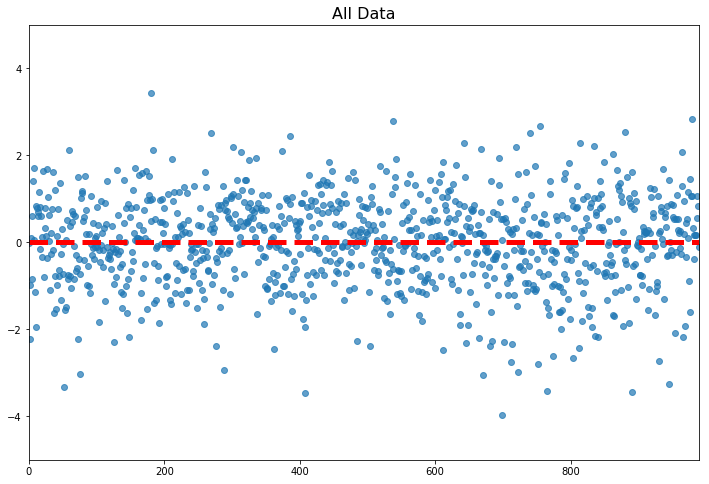

In [28]:
def plot_residuals(fit, X):
    fit.resid.plot(style='o', figsize=(12,8), use_index=False, alpha=0.7, zorder=1)
    plt.hlines(y=0, xmin=0, xmax=len(X), zorder=2, lw=5, colors='r', linestyles='dashed')
    plt.ylim(-5,5);

plot_residuals(fit, X)
plt.title('All Data', fontsize=16)

In [29]:
## Repeat for split data
fit_limited = get_ols_fit(X_limited, y_limited)
fit_limited.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     34.50
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.10e-67
Time:                        11:32:58   Log-Likelihood:                -728.17
No. Observations:                 462   AIC:                             1490.
Df Residuals:                     445   BIC:                             1561.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          -248.3468    112.604     -2.205      0.028    -469.649     -27.044
Q('Num_Theaters')                     0.6578      0.035     19.028      0.000       0.590       0.726
Q('runtimeMinutes')                   2.4225      0.467      5.192      0.000       1.505       3.340
Q('release_year')                     0.1226      0.056      2.196      0.029       0.013       0.232
Q('dum_is_Action')                   -0.3678      0.361     -1.018      0.309      -1.078       0.342
Q('dum_is_Adventure')                 0.3924      0.386      1.016      0.310      -0.367       1.151
Q('dum_is_Biography')                 0.4816      0.319      1.508      0.132      -0.146       1.109
Q('dum_is_Comedy')                    0.4056      0.308      1.317      0.188      -0.199       1.011
Q('dum_is_Crime')                     0.1261      0.370      0.341      0.733      -0.600       0.852
Q('dum_is_Drama')                     0.0119      0.305      0.039      0.969      -0.587       0.611
Q('dum_is_Horror')                   -0.7249      0.452     -1.602      0.110      -1.614       0.164
Q('dum_rated_PG-13')                 -0.0586      0.243     -0.241      0.809      -0.536       0.418
Q('dum_rated_R')                     -0.2042      0.236     -0.866      0.387      -0.668       0.259
Q('dum_release_in_spring')            0.1934      0.152      1.276      0.203      -0.104       0.491
Q('dum_release_in_summer')            0.3278      0.155      2.118      0.035       0.024       0.632
Q('dum_release_in_winter')            0.1579      0.180      0.879      0.380      -0.195       0.511
Q('average_star_rank_12_month_5')    -0.1151      0.035     -3.267      0.001      -0.184      -0.046
==============================================================================
Omnibus:                        7.749   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.721
Skew:                          -0.314   Prob(JB):                       0.0211
Kurtosis:                       3.076   Cond. No.                     4.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
fit_limited.pvalues[fit_limited.pvalues > 0.1].sort_values()

Q('dum_is_Horror')            0.109817
Q('dum_is_Biography')         0.132169
Q('dum_is_Comedy')            0.188397
Q('dum_release_in_spring')    0.202585
Q('dum_is_Action')            0.309154
Q('dum_is_Adventure')         0.310216
Q('dum_release_in_winter')    0.379619
Q('dum_rated_R')              0.387142
Q('dum_is_Crime')             0.733104
Q('dum_rated_PG-13')          0.809341
Q('dum_is_Drama')             0.968902
dtype: float64

In [31]:
drop_labels_limited = find_unnecessary_features(fit_limited, 0.02)
fit_limited = get_ols_fit(X_limited.drop(drop_labels_limited, axis=1), y_limited)
fit_limited.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     158.7
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.57e-70
Time:                        11:32:58   Log-Likelihood:                -749.86
No. Observations:                 462   AIC:                             1508.
Df Residuals:                     458   BIC:                             1524.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.1327      2.109     -0.537      0.591      -5.277       3.011
Q('Num_Theaters')                     0.6559      0.033     19.590      0.000       0.590       0.722
Q('runtimeMinutes')                   2.4769      0.442      5.605      0.000       1.609       3.345
Q('average_star_rank_12_month_5')    -0.1320      0.034     -3.855      0.000      -0.199      -0.065
==============================================================================
Omnibus:                       19.133   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.372
Skew:                          -0.503   Prob(JB):                     3.77e-05
Kurtosis:                       3.212   Cond. No.                         380.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

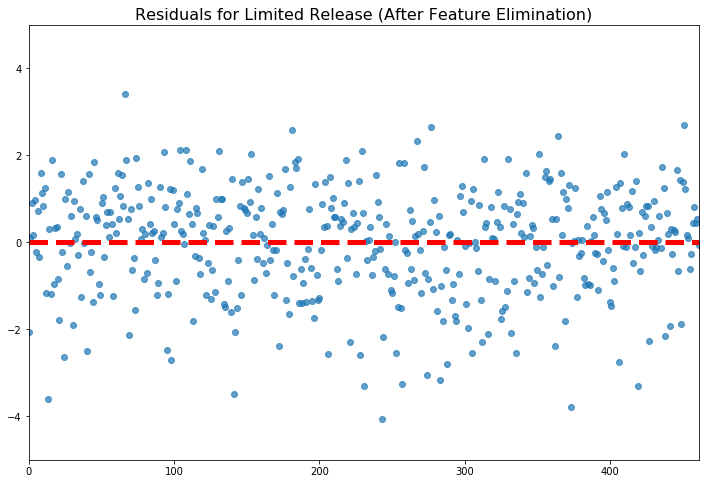

In [32]:
plot_residuals(fit_limited, X_limited)
plt.title('Residuals for Limited Release (After Feature Elimination)', fontsize=16)

In [33]:
## Repeat for split data (wide)
fit_wide = get_ols_fit(X_wide, y_wide)
fit_wide.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     63.72
Date:                Mon, 29 Jan 2018   Prob (F-statistic):          1.76e-110
Time:                        11:32:58   Log-Likelihood:                -544.01
No. Observations:                 528   AIC:                             1122.
Df Residuals:                     511   BIC:                             1195.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           189.1722     57.438      3.294      0.001      76.329     302.015
Q('Num_Theaters')                     1.6340      0.077     21.183      0.000       1.482       1.786
Q('runtimeMinutes')                   1.4929      0.253      5.912      0.000       0.997       1.989
Q('release_year')                    -0.0951      0.028     -3.350      0.001      -0.151      -0.039
Q('dum_is_Action')                   -0.2478      0.256     -0.968      0.334      -0.751       0.255
Q('dum_is_Adventure')                -0.2825      0.259     -1.090      0.276      -0.791       0.227
Q('dum_is_Biography')                -0.4186      0.272     -1.537      0.125      -0.954       0.116
Q('dum_is_Comedy')                   -0.3339      0.261     -1.279      0.202      -0.847       0.179
Q('dum_is_Crime')                    -0.2966      0.293     -1.014      0.311      -0.872       0.278
Q('dum_is_Drama')                    -0.5223      0.264     -1.975      0.049      -1.042      -0.003
Q('dum_is_Horror')                   -0.1273      0.280     -0.455      0.649      -0.677       0.423
Q('dum_rated_PG-13')                 -0.1804      0.105     -1.722      0.086      -0.386       0.025
Q('dum_rated_R')                     -0.3989      0.107     -3.737      0.000      -0.609      -0.189
Q('dum_release_in_spring')            0.3277      0.090      3.636      0.000       0.151       0.505
Q('dum_release_in_summer')            0.1569      0.086      1.830      0.068      -0.012       0.325
Q('dum_release_in_winter')            0.0947      0.085      1.119      0.264      -0.072       0.261
Q('average_star_rank_12_month_5')    -0.0911      0.025     -3.606      0.000      -0.141      -0.041
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.310   Jarque-Bera (JB):                2.238
Skew:                          -0.085   Prob(JB):                        0.327
Kurtosis:                       3.270   Cond. No.                     3.86e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
fit_wide.pvalues[fit_wide.pvalues > 0.1].sort_values()

Q('dum_is_Biography')         0.124822
Q('dum_is_Comedy')            0.201543
Q('dum_release_in_winter')    0.263821
Q('dum_is_Adventure')         0.276143
Q('dum_is_Crime')             0.311245
Q('dum_is_Action')            0.333597
Q('dum_is_Horror')            0.649468
dtype: float64

In [35]:
drop_labels_wide = find_unnecessary_features(fit_wide, 0.02)
fit_wide = get_ols_fit(X_wide.drop(drop_labels_wide, axis=1), y_wide)
fit_wide.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     163.8
Date:                Mon, 29 Jan 2018   Prob (F-statistic):          1.73e-116
Time:                        11:32:58   Log-Likelihood:                -553.75
No. Observations:                 528   AIC:                             1122.
Df Residuals:                     521   BIC:                             1151.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           168.7412     57.124      2.954      0.003      56.520     280.962
Q('Num_Theaters')                     1.7260      0.071     24.449      0.000       1.587       1.865
Q('runtimeMinutes')                   1.1996      0.233      5.140      0.000       0.741       1.658
Q('release_year')                    -0.0848      0.028     -3.004      0.003      -0.140      -0.029
Q('dum_rated_R')                     -0.2444      0.065     -3.785      0.000      -0.371      -0.118
Q('dum_release_in_spring')            0.2481      0.074      3.354      0.001       0.103       0.393
Q('average_star_rank_12_month_5')    -0.0818      0.024     -3.400      0.001      -0.129      -0.035
==============================================================================
Omnibus:                        1.843   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.398   Jarque-Bera (JB):                1.670
Skew:                          -0.081   Prob(JB):                        0.434
Kurtosis:                       3.223   Cond. No.                     3.81e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

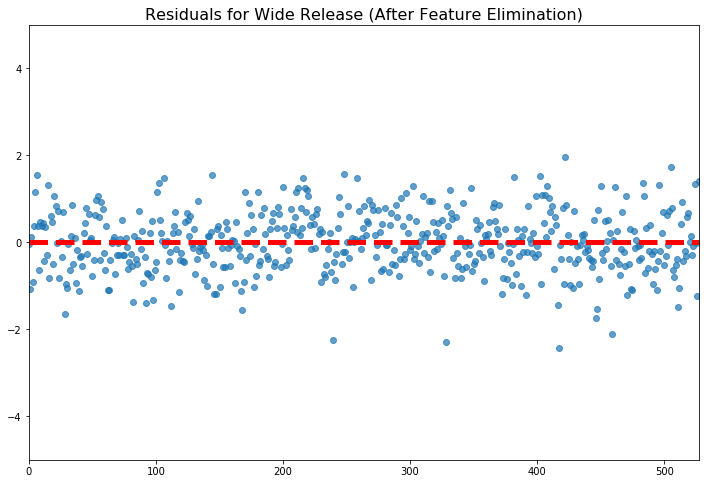

In [36]:
plot_residuals(fit_wide, X_wide)
plt.title('Residuals for Wide Release (After Feature Elimination)', fontsize=16)

In [37]:
# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)
# scaler.fit(X_limited)
# X_limited = scaler.transform(X_limited)
# scaler.fit(X_wide)
# X_wide = scaler.transform(X_wide)

# scaler = MinMaxScaler()
# scaler.fit(y)
# y = scaler.transform(y)
# scaler.fit(y_limited)
# y_limited = scaler.transform(y_limited)
# scaler.fit(y_wide)
# y_wide = scaler.transform(y_wide)

In [38]:
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X.drop(drop_labels, axis=1), y, test_size=test_size, random_state=42)
X_train_limited, X_test_limited, y_train_limited, y_test_limited = train_test_split(X_limited.drop(drop_labels_limited, axis=1), y_limited, test_size=test_size, random_state=42)
X_train_wide, X_test_wide, y_train_wide, y_test_wide = train_test_split(X_wide.drop(drop_labels_wide, axis=1), y_wide, test_size=test_size, random_state=42)

In [39]:
lr = LinearRegression()
lr_limited = LinearRegression()
lr_wide = LinearRegression()

In [40]:
lr.fit(X_train, y_train)
lr_limited.fit(X_train_limited, y_train_limited)
lr_wide.fit(X_train_wide, y_train_wide)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
print(lr.score(X_train, y_train))
print(lr_limited.score(X_train_limited, y_train_limited))
print(lr_wide.score(X_train_wide, y_train_wide))

0.193920268093
0.499940153717
0.685542568936


In [42]:
y_pred = lr.predict(X_test)
y_pred_limited = lr_limited.predict(X_test_limited)
y_pred_wide = lr_wide.predict(X_test_wide)

print(lr.score(X_test, y_test))
print(lr_limited.score(X_test_limited, y_test_limited))
print(lr_wide.score(X_test_wide, y_test_wide))

0.174682879626
0.511916728568
0.521906017903


In [43]:
# # Try K-Fold Cross Validation
# k = 5
# kf = KFold(n_splits=k)
# for train_index, test_index in kf.split(X_limited):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train_limited, X_test_limited = X_limited.iloc[train_index], X_limited.iloc[test_index]
#     y_train_limited, y_test_limited = y_limited.iloc[train_index], y_limited.iloc[test_index]
#     lr_limited = LinearRegression()
#     lr_limited.fit(X_train_limited, y_train_limited)
#     y_pred_limited = lr_limited.predict(X_test_limited)
#     print(lr_limited.score(X_train_limited, y_train_limited))
#     print(lr_limited.score(X_test_limited, y_test_limited))
#     print('----')

(3, 12)

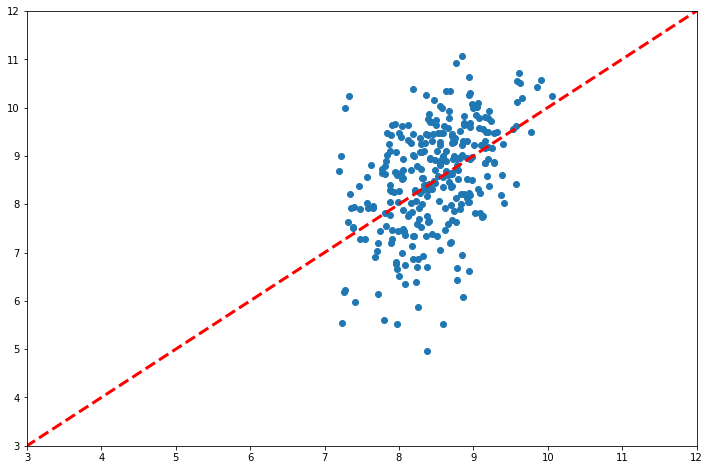

In [44]:
plt.figure(figsize=(12,8))
plt.scatter(y_pred, y_test)
plt.plot([0, 15], [0, 15], 'r--', lw=3)
plt.ylim(3,12)
plt.xlim(3,12)

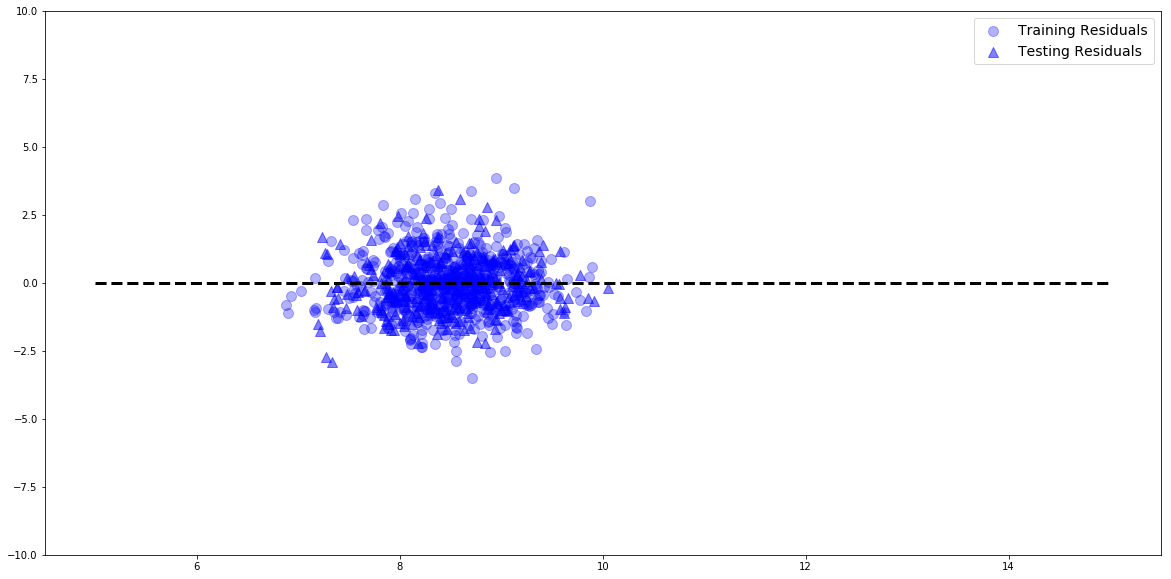

In [45]:
# Plot residuals
plt.figure(figsize=(20,10))
plt.scatter(lr.predict(X_train), lr.predict(X_train) - y_train, c='blue', alpha=0.3, s=100, label='Training Residuals')
plt.scatter(y_pred, y_pred - y_test, c='blue', marker='^', alpha=0.5, s=100, label='Testing Residuals')
plt.hlines(y=0, xmin=5, xmax=15, colors='k', linestyles='--', lw=3)
plt.ylim(-10,10)
plt.legend(fontsize=14)

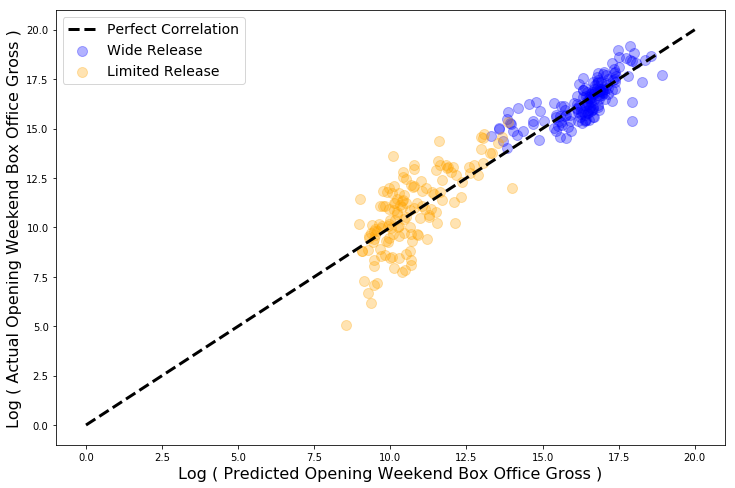

In [46]:
plt.figure(figsize=(12,8))
plt.scatter(y_pred_wide, y_test_wide, c='blue', alpha=0.3, s=100, label='Wide Release')
plt.scatter(y_pred_limited, y_test_limited, c='orange', alpha=0.3, s=100, label='Limited Release')
# plt.plot([0, 1], [0, 1], 'k--', lw=3, label='Perfect Correlation')
plt.plot([0, 20], [0, 20], 'k--', lw=3, label='Perfect Correlation')
plt.legend(fontsize=14)
plt.xlabel("Log ( Predicted Opening Weekend Box Office Gross )", fontsize=16)
plt.ylabel("Log ( Actual Opening Weekend Box Office Gross )", fontsize=16)

In [47]:
# stats.probplot(fit.resid, dist = 'norm', plot=plt)

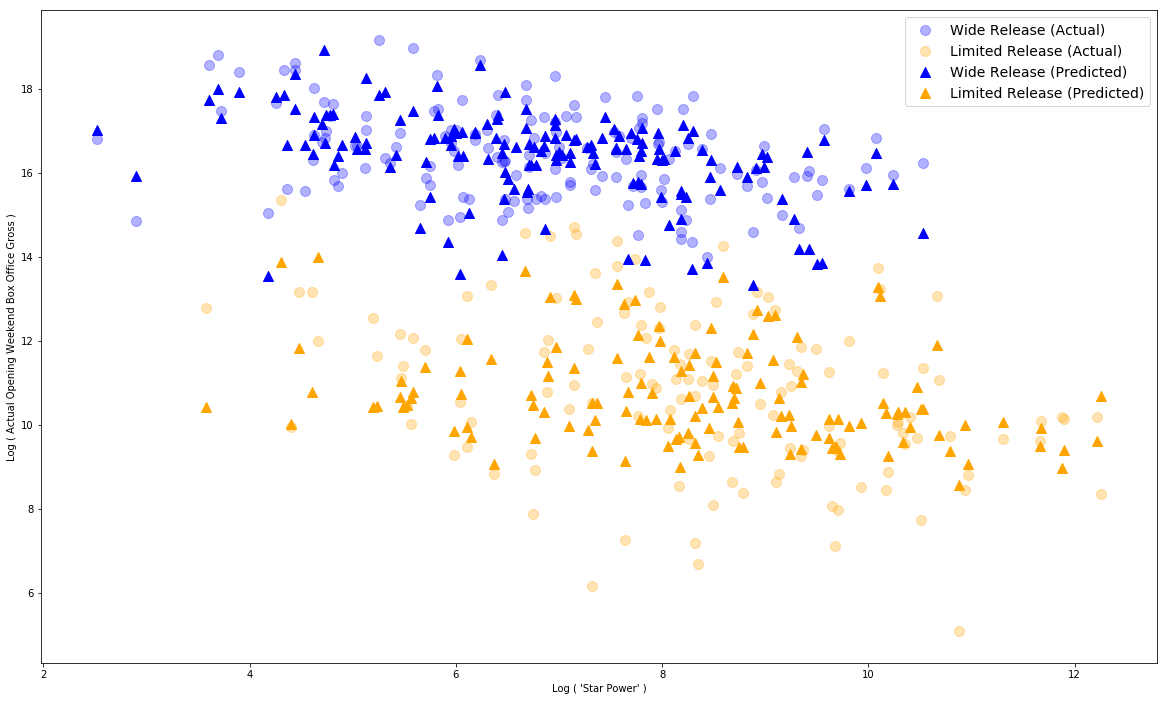

In [48]:
plt.figure(figsize=(20,12))
# Actual Data
plt.scatter(X_test_wide.average_star_rank_12_month_5, y_test_wide, c='blue', alpha=0.3, s=100, label='Wide Release (Actual)')
plt.scatter(X_test_limited.average_star_rank_12_month_5, y_test_limited, c='orange', alpha=0.3, s=100, label='Limited Release (Actual)')

# Predicted Data
plt.scatter(X_test_wide.average_star_rank_12_month_5, y_pred_wide, c='blue', marker='^', alpha=1, s=100, label='Wide Release (Predicted)')
plt.scatter(X_test_limited.average_star_rank_12_month_5, y_pred_limited, c='orange', marker='^', alpha=1, s=100, label='Limited Release (Predicted)')

plt.legend(fontsize=14)

plt.xlabel("Log ( 'Star Power' )")
plt.ylabel("Log ( Actual Opening Weekend Box Office Gross )")

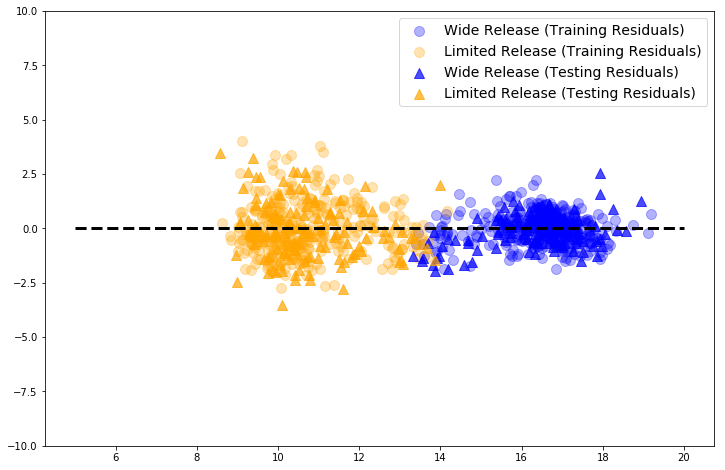

In [49]:
# Plot residuals
plt.figure(figsize=(12,8))
plt.scatter(lr_wide.predict(X_train_wide), lr_wide.predict(X_train_wide) - y_train_wide, c='blue', alpha=0.3, s=100, label='Wide Release (Training Residuals)')
plt.scatter(lr_limited.predict(X_train_limited), lr_limited.predict(X_train_limited) - y_train_limited, c='orange', alpha=0.3, s=100, label='Limited Release (Training Residuals)')
plt.scatter(y_pred_wide, y_pred_wide - y_test_wide, c='blue', marker='^', alpha=0.7, s=100, label='Wide Release (Testing Residuals)')
plt.scatter(y_pred_limited, y_pred_limited - y_test_limited, c='orange', marker='^', alpha=0.7, s=100, label='Limited Release (Testing Residuals)')
plt.hlines(y=0, xmin=5, xmax=20, colors='k', linestyles='--', lw=3)
plt.ylim(-10,10)
plt.legend(fontsize=14)

In [50]:
## CROSS VALIDATION
def get_cross_val_score(n_folds, X, y):
    est=LinearRegression()

    kf=KFold(n=len(X),n_folds=n_folds,shuffle=True, random_state=1)

    all_scores=[]

    # Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
    # us to 'manipulate' our training set, 


    # get indices of corresponding train & test
    for train,test in kf:
        x_train=X.iloc[train]
        y_train=y.iloc[train]
        x_test=X.iloc[test]
        y_test=y.iloc[test]
        pvals=[]
        sig_cols=[]

#         for feature in x_train.columns:
#             pval=f_select.f_regression(x_train[[feature]],y_train)
#             if pval[1][0]<.02: 
#                 sig_cols.append(feature)
#                 pvals.append(pval[1][0])

#         est.fit(x_train[sig_cols],y_train)
#         r_2=est.score(x_test[sig_cols],y_test)
        est.fit(x_train, y_train)
        r_2=est.score(x_test,y_test)
        all_scores.append(r_2)

    return np.mean(all_scores)

In [51]:
# FOR ALL DATA
before_score = get_cross_val_score(10, X, y)
after_score = get_cross_val_score(10, X.drop(drop_labels, axis=1), y)
print("Before Feature Selection: %0.4f" % before_score)
print("After Feature Selection:  %0.4f" % after_score)
print("%% Improvement: %0.2f%%" % ((after_score - before_score) / before_score * 100))
for feature in X.drop(drop_labels, axis=1).columns:
    print('   - %s' % feature)

Before Feature Selection: 0.1637
After Feature Selection:  0.1609
% Improvement: -1.70%
   - Num_Theaters
   - runtimeMinutes
   - dum_rated_R
   - dum_release_in_spring
   - dum_release_in_summer
   - dum_release_limited
   - average_star_rank_12_month_5


In [52]:
# For Limited Release
before_score = get_cross_val_score(10, X_limited, y_limited)
after_score = get_cross_val_score(10, X_limited.drop(drop_labels_limited, axis=1), y_limited)
print("Before Feature Selection: %0.4f" % before_score)
print("After Feature Selection:  %0.4f" % after_score)
print("%% Improvement: %0.2f%%" % ((after_score - before_score) / before_score * 100))
for feature in X_limited.drop(drop_labels_limited, axis=1).columns:
    print('   - %s' % feature)

Before Feature Selection: 0.4943
After Feature Selection:  0.4847
% Improvement: -1.95%
   - Num_Theaters
   - runtimeMinutes
   - average_star_rank_12_month_5


In [53]:
# For Wide Release
before_score = get_cross_val_score(10, X_wide, y_wide)
after_score = get_cross_val_score(10, X_wide.drop(drop_labels_wide, axis=1), y_wide)
print("Before Feature Selection: %0.4f" % before_score)
print("After Feature Selection:  %0.4f" % after_score)
print("%% Improvement: %0.2f%%" % ((after_score - before_score) / before_score * 100))
print('Features Used:')
for feature in X_wide.drop(drop_labels_wide, axis=1).columns:
    print('   - %s' % feature)

Before Feature Selection: 0.6303
After Feature Selection:  0.6356
% Improvement: 0.83%
Features Used:
   - Num_Theaters
   - runtimeMinutes
   - release_year
   - dum_rated_R
   - dum_release_in_spring
   - average_star_rank_12_month_5


In [54]:
# df[df['release'] > datetime(2018,1,1)]

In [55]:
# Predict 2018
from datetime import datetime
limited_names = ['I, Tonya']
X_limited.loc[limited_names].drop(drop_labels_limited, axis=1)
y_predicted = lr_limited.predict(X_limited.loc[limited_names].drop(drop_labels_limited, axis=1))
y_limited.loc[limited_names].apply(np.exp)

,Price
title,
"I, Tonya",264155.0


In [56]:
np.exp(y_predicted[0][0])

45522.003212179348

In [57]:
wide_names = list(X_wide[X_wide['release_year'] == 2018].index)
y_predicted = lr_wide.predict(X_wide.loc[wide_names].drop(drop_labels_wide, axis=1))
y_wide.loc[wide_names].apply(np.exp)

,Price
title,
The Post,19887979.0
Paddington 2,11001961.0


In [58]:
np.exp(y_predicted[0][0])

18109110.262724251

In [59]:
np.exp(y_predicted[1][0])

19783540.046814632

In [60]:
df_2018 = pd.DataFrame([[19887979,18109110,'wide'],[11001961,19783540,'wide'], [264155, 45522,'limited']], 
             columns=['Actual Gross', 'Predicted Gross', 'Release Type'],
             index = ['The Post', 'Paddington 2', 'I, Tonya'])
df_2018['% Error'] = (df_2018['Predicted Gross'] - df_2018['Actual Gross'])/df_2018['Actual Gross']*100
df_2018

,Actual Gross,Predicted Gross,Release Type,% Error
The Post,19887979,18109110,wide,-8.944443
Paddington 2,11001961,19783540,wide,79.818307
"I, Tonya",264155,45522,limited,-82.766936


In [61]:
from sklearn.linear_model import RidgeCV
from sklearn import preprocessing

X_trans=preprocessing.normalize(X_wide.join(y_wide),axis=0)
X_trans=pd.DataFrame(X_trans,columns=X_wide.join(y_wide).columns)
y_trans = X_trans.Price
X_trans.drop('Price', axis=1, inplace=True)

X_trans.describe()



rcv = RidgeCV(cv=10)
rcv.fit(X_trans, y_trans)
rcv.score(X_trans, y_trans)

0.27912849345473056

In [62]:
X_trans.columns

Index(['Num_Theaters', 'runtimeMinutes', 'release_year', 'dum_is_Action',
       'dum_is_Adventure', 'dum_is_Biography', 'dum_is_Comedy', 'dum_is_Crime',
       'dum_is_Drama', 'dum_is_Horror', 'dum_rated_PG-13', 'dum_rated_R',
       'dum_release_in_spring', 'dum_release_in_summer',
       'dum_release_in_winter', 'average_star_rank_12_month_5'],
      dtype='object')

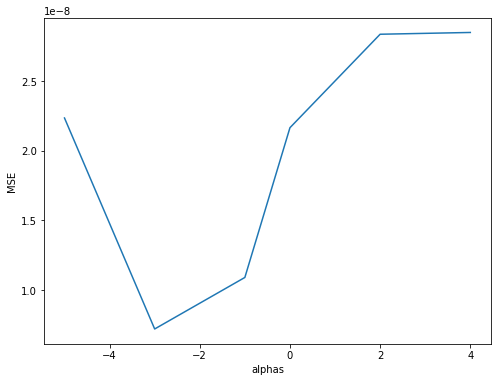

In [63]:
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')

# Test, train, split option via Ridge 
alphas=[1e-5,1e-3,1e-1,1,100,10000]
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.3)

def make_estimator(est,alpha):
    est.alpha=alpha
    model = est.fit(X_train,y_train)
    mse=np.mean(y_test-model.predict(X_test))**2
    return mse
    
# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [64]:
# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.3)

est=Ridge(alpha=0)
est.fit(X_train,y_train)
est.alpha


zipped=zip(X.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features

[('Num_Theaters', 0.75220658654770844),
 ('runtimeMinutes', 0.43656018021115522),
 ('dum_release_in_spring', 0.00850905441098628),
 ('dum_release_in_summer', 0.0034386750808984611),
 ('dum_release_in_winter', 0.0011894336191176898),
 ('dum_rated_PG-13', -0.0078215643483031151),
 ('dum_is_Horror', -0.0092233595266228256),
 ('dum_is_Crime', -0.011200915301482201),
 ('dum_is_Adventure', -0.016693736804900106),
 ('dum_rated_R', -0.017230206669825804),
 ('dum_is_Biography', -0.019465556833142574),
 ('dum_is_Comedy', -0.021377615997279113),
 ('dum_is_Drama', -0.024825472305043603),
 ('dum_release_limited', -0.026087358708045901),
 ('dum_is_Action', -0.028329431581308465),
 ('release_year', -9.9730100562763848)]

In [65]:
# A bit more involved approach: illustrated here with Lasso
from sklearn.linear_model import Lasso
kf = KFold(len(X_trans),n_folds=5, shuffle=True)

all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1,100]

for train, test in kf:
    x_train=X_trans.iloc[train]
    y_train=y_trans.iloc[train]
    x_test=X_trans.iloc[test]
    y_test=y_trans.iloc[test]
    mse_score=[]
    r2 = []
    for a in alphas:
        est=Lasso(alpha=a,tol=0.001)
        est.fit(x_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
        r2.append(est.score(x_test,y_test))
            
    all_scores.append(mse_score)
# all_scores

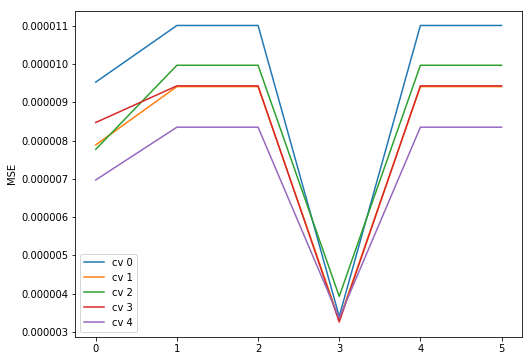

In [66]:
# Which alpha is the best for our model ? Looks like alpha= 0
plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
    
plt.legend()
plt.ylabel('MSE')
plt.show()

In [67]:
# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.3)

est=Lasso(alpha=0)
est.fit(X_train,y_train)
est.alpha


zipped=zip(X.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features

[('Num_Theaters', 0.75663391280453041),
 ('runtimeMinutes', 0.43724226705614727),
 ('dum_release_in_spring', 0.010666951907136136),
 ('dum_release_in_winter', 0.0053814161467495578),
 ('dum_release_in_summer', 0.0040771127514371034),
 ('dum_is_Horror', -0.0037106933502164263),
 ('dum_rated_PG-13', -0.0070658857403396941),
 ('dum_is_Crime', -0.0072034516779924456),
 ('dum_is_Adventure', -0.0096047880360089887),
 ('dum_is_Biography', -0.012099084561499782),
 ('dum_is_Comedy', -0.012618590072187942),
 ('dum_is_Action', -0.01354250355331877),
 ('dum_rated_R', -0.016980408048495193),
 ('dum_is_Drama', -0.01784953947438473),
 ('dum_release_limited', -0.036951465462062072),
 ('release_year', -14.196493929113803)]

In [68]:
lr_wide.coef_

array([[ 1.9312177 ,  1.03418673, -0.0832017 , -0.18427171,  0.20929063,
        -0.09315404]])

In [69]:
import pickle
with open('Pre_Processed_IMDB_Data_with_dummies.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)
df.head()

,tconst,primaryProfession,mpaa_rating,metacritic_score,averageRating,release,genres,Num_Theaters,Price,runtimeMinutes,release_year,release_season,weighted_score,opening_per_theater,release_1_month_prev,release_6_month_prev,release_12_month_prev,average_star_rank_12_month_1,average_star_rank_12_month_2,average_star_rank_12_month_3,...,is_Comedy,is_Crime,is_Drama,is_Family,is_Fantasy,is_Horror,is_Mystery,is_Romance,is_Sci-Fi,is_Thriller,rated_G,rated_PG,rated_PG-13,rated_R,release_in_spring,release_in_summer,release_in_winter,release_limited,log_average_star_rank_12_month_5,log_Price
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A Walk Among the Tombstones,tt0365907,producer,R,57,6.5,2014-09-19,Crime,2712,12758780,114.0,2014,summer,6.10,4704.564897,2014-08-20,2014-03-23,2013-09-24,46.0,56.0,171.000000,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,7.025361,16.361730
Pride and Prejudice and Zombies,tt1374989,producer,PG-13,45,5.8,2016-02-05,Action,2931,5324240,108.0,2016,winter,5.15,1816.526783,2016-01-06,2015-08-09,2015-02-10,3.0,34.5,50.666667,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,6.956545,15.487781
Clown,tt1780798,producer,R,42,5.7,2016-06-17,Horror,100,26920,100.0,2016,spring,4.95,269.200000,2016-05-18,2015-12-20,2015-06-23,196.0,208.0,234.333333,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,7.770392,10.200625
American Made,tt3532216,producer,R,65,7.2,2017-09-29,Action,3024,16776390,115.0,2017,autumn,6.85,5547.748016,2017-08-30,2017-04-02,2016-10-04,3.0,6.0,22.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5.039547,16.635483
The Quiet Ones,tt2235779,producer,PG-13,41,5.1,2014-04-25,Horror,2027,3880053,98.0,2014,spring,4.60,1914.185002,2014-03-26,2013-10-27,2013-04-30,98.0,384.5,507.000000,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,8.753087,15.171359
